In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw6.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

#### Instructions
- **THIS IS AN INDIVIDUAL ASSIGNMENT. Collaboration on this homework IS NOT PERMITTED.**
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree [21 pts]**](#part1)


- [**Question 2: Bagging [20 pts]**](#part2) 


- [**Question 3: Random Forests [14 pts]**](#part3) 


- [**Question 4: Boosting [30 pts]**](#part4) 


- [**Question 5: Understanding [15 pts]**](#part5) 
  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

In [4]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree [21 pts]</div> 
    
[Return to contents](#contents)
    

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Store the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds` respectively.
</div>

_Points:_ 7

In [5]:
# your code here

# Creating a list to store the scores on the training set:
train_scores = []
cvmeans, cvstds = [], []

# Considering each tree depth from 1-20 inclusive:
ks = [k for k in range(1,21)]

# Fitting a decision tree classifier for each k:

for k in ks:
    
    # Initialising model
    dtree = DecisionTreeClassifier(max_depth=k)
    
    # Fitting on training data:
    dtree.fit(X_train, y_train)
    
    # Appending training scores to train_scores list:
    train_scores.append(dtree.score(X_train, y_train))
    
    # Performing 5-fold cross_validation and appending scores to list:
    scores = cross_val_score(dtree, X_train, y_train, cv=5)
    
    # Mean validation score:
    cvmeans.append(scores.mean())
    
    # Validation standard deviation:
    cvstds.append(scores.std())
    

# Making our previously defined lists numpy arrays:
cvmeans, cvstds = np.array(cvmeans), np.array(cvstds) 
    
    

In [6]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**1.2** Now that we have `train_scores`, `cvmeans`, and `cvstds`, let's plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

_Points:_ 7

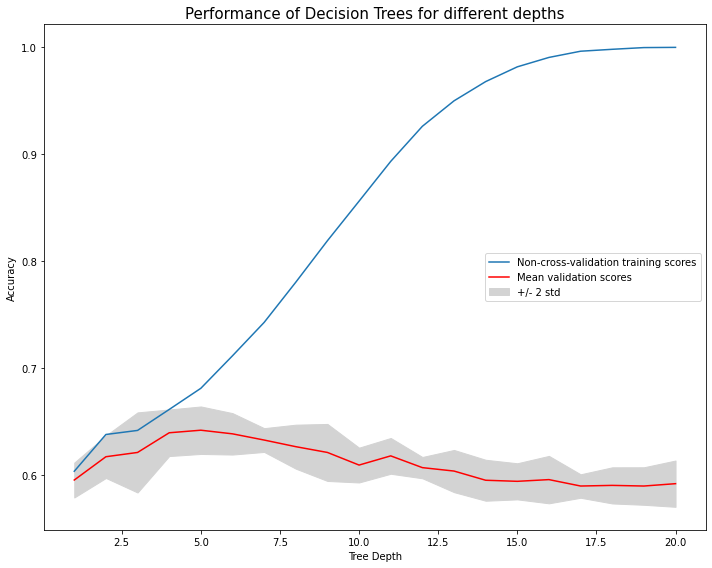

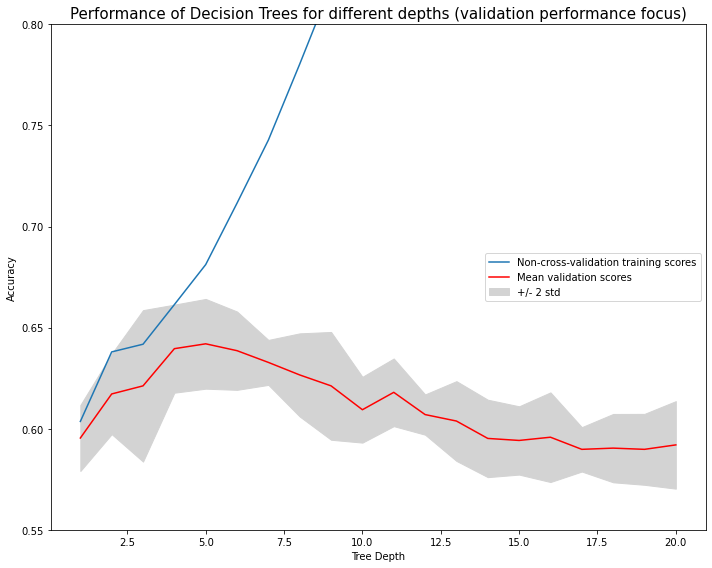

In [7]:
# your code here

plt.figure(figsize=(10,8))
plt.plot(ks,train_scores,label="Non-cross-validation training scores")
plt.plot(ks,cvmeans,label="Mean validation scores", color='red')
plt.fill_between(ks, cvmeans-2*cvstds, cvmeans+2*cvstds,label='+/- 2 std',color="lightgrey")
plt.legend(loc="right")
plt.xlabel("Tree Depth")
plt.ylabel('Accuracy')
plt.title("Performance of Decision Trees for different depths", fontsize=15)
plt.tight_layout();

plt.figure(figsize=(10,8))
plt.plot(ks,train_scores,label="Non-cross-validation training scores")
plt.plot(ks,cvmeans,label="Mean validation scores", color='red')
plt.fill_between(ks, cvmeans-2*cvstds, cvmeans+2*cvstds,label='+/- 2 std',color="lightgrey")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend(loc="right")
plt.title("Performance of Decision Trees for different depths (validation performance focus)", fontsize=15)
plt.ylim(0.55,0.8)
plt.tight_layout();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, store it in `best_cv_depth`, and **justify your choice**. Then, using this depth, fit a new decision tree on the entire training data and store the train and test accuracies in `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

_Points:_ 4

The objective here is to pick a depth which will allow our model to generalise well, and hence to avoid overfitting on the training data. From the plots, choosing a depth that is too high results in our model performing too well omn the testing set. Hence, we choose the depth which will give us the highest mean validation scores. A quick look at our plots will show us that it is **5** that gives us the best bias-variance tradeoff, which can be confirmed analytically with "np.where" (see below). 

In [8]:
# your code here
# Chose best depth after a qualitative assessment of our plots

best_cv_depth = ks[np.where(cvmeans==max(cvmeans))[0][0]]
print(f"Best CV depth is {best_cv_depth}")


dtree_best = DecisionTreeClassifier(max_depth = best_cv_depth)
dtree_best.fit(X_train, y_train)

best_cv_tree_train_score = dtree_best.score(X_train, y_train)
best_cv_tree_test_score = dtree_best.score(X_test, y_test)

Best CV depth is 5


In [9]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 5 trained on the full training set, achieves the following accuracy scores:

	train	0.6812
	TEST	0.6478


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.4** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth?

</div>

_Points:_ 3

In terms of the bias-variance tradeoff, limiting tree depth avoids over-fitting by increasing training-set bias, which will in turn reduce the model's variance. Reduced tree depth leads to a more complex and general model, in turn leading to less variance. In parallel, this makes sure the model does not learn the full complexity of the training set, which induces training bias to a certain extent. 

A potential downside of limiting tree is an oversimplified model, which would have not learned *enough* complexity from the training set. This would then be characteristic of *underfitting*, and can result in bias. 

<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging [20 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

_Points:_ 3

Looking at our Q1 plots suggests that a Decision Tree Classifier of depth 20 would prove itself 100% (train accuracy of 1) accurate on the training set whilst performing very poorly on the validation set (validation score of $ \approx 0.6$). This can be confirmed below. 
This means that the model performs well on training data, but poorly on testing data (that it has never seen before). Increasing our model complexity leads to our tree creating too many splits. It then starts to fit the noise of the training data which leads to poor generalisation. 

In [10]:
# set overfitting tree_depth based on provided rationale 
tree_depth = 20

overfitting_tree = DecisionTreeClassifier(max_depth = tree_depth)
overfitting_tree.fit(X_train, y_train)

print(f"Train accuracy score for depth {tree_depth} tree:", overfitting_tree.score(X_train, y_train))
print(f"Validation accuracy score for depth {tree_depth} tree:", overfitting_tree.score(X_test, y_test))

Train accuracy score for depth 20 tree: 1.0
Validation accuracy score for depth 20 tree: 0.603


<!-- END QUESTION -->

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- Using a random seed of 0, call the provided `bagger` function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps are returned by the `bagger` function as dataframes formatted like the example shown below. Each row represents one observation (from either the training or test set depending on the dataframe), and each column represents one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

An example of the `bagging_train_df` and `bagging_test_df` dataframes would be:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

</div>

_Points:_ 1

In [11]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [12]:
# specify number of required bootrapped trees
n_trees = 55 

In [13]:
# generate predictions using bagger function

# Tree depth used here: 20

bagging_train_df, bagging_test_df, bagging_models_list = bagger(n_trees, tree_depth, X_train, y_train, X_test)

In [14]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1
3,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1,1
1,0,1,1,0,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0
2,1,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0
3,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,1,0


In [15]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`.

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

_Points:_ 4

In [16]:
# evaluate accuracy on our bagged prediction results

N = len(bagging_train_df)
train_predictions = [np.bincount(bagging_train_df.iloc[i].values).argmax() for i in range(N)]
test_predictions = [np.bincount(bagging_test_df.iloc[i].values).argmax() for i in range(N)]

bagging_accuracy_train = accuracy_score(y_train, train_predictions)
bagging_accuracy_test = accuracy_score(y_test, test_predictions)

In [17]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-20 achieves the following accuracy scores:

	train	0.9998
	TEST	0.6846

Our prior single depth-5 tree achieved a TEST score of 0.6478.


In [18]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

</div>

_Points:_ 7

In [19]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "bagger_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


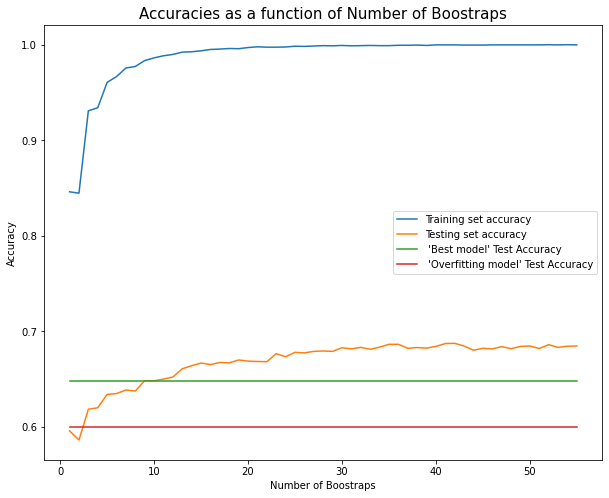

In [20]:
# your code here

# Computing Test accuracy of best model from Q1:

dtree_best = DecisionTreeClassifier(max_depth = best_cv_depth)
dtree_best.fit(X_train, y_train)

accuracy_1 = dtree_best.score(X_test, y_test)

# Computing Test accuracy of overfitting decision tree:
overfitting_tree = DecisionTreeClassifier(max_depth = tree_depth)
overfitting_tree.fit(X_train, y_train)

accuracy_2 = overfitting_tree.score(X_test, y_test)


# 𝑗 ∈ [1,2,3,...,55]
n_bstrp = [i for i in range(1,56)]

# Using `running_predictions` function to issue predictions:
run_pred_train = running_predictions(bagging_train_df, y_train)
run_pred_test = running_predictions(bagging_test_df, y_test)

# Plotting:
plt.figure(figsize=(10, 8))
plt.plot(n_bstrp, run_pred_train, label="Training set accuracy")
plt.plot(n_bstrp, run_pred_test, label="Testing set accuracy")
plt.plot(n_bstrp, [accuracy_1 for _ in range(55)],label=" 'Best model' Test Accuracy")
plt.plot(n_bstrp, [accuracy_2 for _ in range(55)],label=" 'Overfitting model' Test Accuracy")
plt.xlabel("Number of Boostraps")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracies as a function of Number of Boostraps", fontsize = 15)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain what you see in terms of the differences between how bagging and limiting tree depth work to control overfitting.

</div>

_Points:_ 5

The performance of bagging against the baseline of a single `tree_depth` tree is significantly better. This is because we bag 55 trees of depth 20, which overfits the training set and thus rapidly gives us an accuracy of 1 as we increase the number of bootstraps. 
However, by definition, bagging cannot learn every single complexity of the training set as the sample changes at each iteration with bootstrapping. This enables deep decision trees to capture complex decision boundaries, while avoiding overfitting. By taking the average, bagging is able to reduce the variance in the final prediction (under the assumption that we have chosen a sufficiently large number of trees). 

This reduces overfitting, thus improving test accuracy, which is highly evidenced in the plot as testing set accuracy for this model surpasses test accuracy for our two previous ones roughly at the 10-bootstraps mark. 

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests [14 pts]</div> 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate classifier's accuracy on the training and test sets and store them in `random_forest_train_score` and `random_forest_test_score`.

</div>

_Points:_ 3

In [21]:
# evaluate results

# Specifying number of estimators:
n_estimators = 55

# Initialising the random forest classifier with desired specifications:
rand_forest = RandomForestClassifier(n_estimators = 55, max_depth = tree_depth, max_features = 'auto')

# Fitting it on training data:
rand_forest.fit(X_train, y_train)

# Scoring:
random_forest_train_score = rand_forest.score(X_train, y_train)
random_forest_test_score = rand_forest.score(X_test, y_test)

In [22]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-20 and 55 trees achieves the following accuracy scores:

	train	1.0000
	TEST	0.6898


In [23]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series Dataframes called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
    
**IMPORTANT:** As always, your output should be easy to interpret. In this context that means construcing your DataFrames with the care, assigning appropriate column names and/or index values to best convey to the reader what the output represents.

</div>

_Points:_ 6

In the case of *bagging*, it is always the 25th feature that is used as top node. 
This is not the case of *random forest*: features to be used at each node are randomly selected meaning that the 25th feature might *not* appear among the possible features for the first split in some trees. 
This means in turn that *random forests are less prone to overfitting than bagging* (because the latter creates trees with the same split) and can achieve higher accuracies.  

In [24]:
# your code here

# We start by printing two pandas series as outlined by the question:

bagging_predictors, random_forest_predictors = {}, {}

# Iterating through our models:
for model in bagging_models_list:
    
    # Retrieving top features in our decision trees:
    feature = model.tree_.feature[0]
    
    if feature not in bagging_predictors:
        
        bagging_predictors[feature] = 1
        
    else: 
        
        bagging_predictors[feature] += 1

for model in rand_forest.estimators_:
    feature = model.tree_.feature[0]
    
    if feature not in random_forest_predictors: 
        
        random_forest_predictors[feature]=1
        
    else: 
        random_forest_predictors[feature] += 1
      
    
feature_names_bagging = [data_train.columns[i] for i in bagging_predictors.keys()]
feature_names_rf = [data_train.columns[i] for i in random_forest_predictors.keys()]

    
bagging_predictors_ = {k:v for k, v in zip(feature_names_bagging, bagging_predictors.values())}
random_forest_predictors_ = {k:v for k, v in zip(feature_names_rf, random_forest_predictors.values())}        
        
        
top_predictors_bagging= pd.Series(bagging_predictors_)
top_predictors_rf = pd.Series(random_forest_predictors_)

In [25]:
# Calling DataFrame constructors for both series objects:
top_predictors_bagging = pd.DataFrame(top_predictors_bagging, columns = ['Frequency as top/first node'])
top_predictors_rf = pd.DataFrame(top_predictors_rf, columns = ['Frequency as top/first node'])

# Setting index names to "Feature"
top_predictors_bagging.index.name, top_predictors_rf.index.name = 'Feature', 'Feature'

In [26]:
#Displaying DataFrames
print("Top predictors bagging")
display(top_predictors_bagging)

print("Top predictors random forest")
display(top_predictors_rf)

Top predictors bagging


,Frequency as top/first node
Feature,
m_bb,55


Top predictors random forest


,Frequency as top/first node
Feature,
m_bb,5
jet 2 eta,1
m_wwbb,11
lepton pT,1
m_jjj,7
m_wbb,11
missing energy magnitude,6
jet 2 b-tag,2
lepton eta,2


In [27]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.3**: Make a Pandas DataFrame (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

_Points:_ 5

"Single overfit depth- 𝑘 tree" performs poorly on both training and testing data: the shallowness of the tree precludes it from fitting complex decision boundaries. This is a sign of poor generalisation and overfitting. 



"Single overfit depth- 𝑘 tree",
                         "Bagging 55 Depth- 𝑘  Trees","Random forest of 55 depth- 𝑘  Trees" overfit on the training data, evidenced by their training accuracy of $\approx 1$. We notice that this is an issue for the case of the "Single overfit depth- 𝑘 tree" which only achieves a test accuracy of $0.6036$. However, for reasons previously outlined, the last two models are still able to generalise well to the testing data and achieve high accuracies. This is because through ensemble methods they are able to smoothe out the decision boundaries. They are able to use deeper trees to make more complex decision boundaries. The generalization is better because ensemble methods have smoother decision boundaries due to the combined knowledge of each model rather than a single model.

In [28]:
# your code here
results = {"Classifier":["Single depth- 𝑖 tree chosen by CV", "Single overfit depth- 𝑘 tree",
                         "Bagging 55 Depth- 𝑘  Trees","Random forest of 55 depth- 𝑘  Trees"],
          "Training Accuracy": [best_cv_tree_train_score, overfitting_tree.score(X_train,y_train), run_pred_train[-1],random_forest_train_score],
          "Test Accuracy": [accuracy_1, accuracy_2,run_pred_test[-1],random_forest_test_score]}

results_df = pd.DataFrame.from_dict(results)
results_df.set_index('Classifier', inplace=True)

In [29]:
# display results
results_df

,Training Accuracy,Test Accuracy
Classifier,,
Single depth- 𝑖 tree chosen by CV,0.6812,0.6482
Single overfit depth- 𝑘 tree,1.0000,0.5998
Bagging 55 Depth- 𝑘 Trees,0.9998,0.6846
Random forest of 55 depth- 𝑘 Trees,1.0000,0.6898


<!-- END QUESTION -->

<a id="part4"></a>

## <div class='exercise'>Question 4: Boosting [30 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

_Points:_ 7

In [30]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


A few commments can be made regarding the above code:

- Global counter variable `q=0` is declared outside of loop: updating it in loop is inefficient and unreadable


- Extensive hardcoding



- Regarding the function attributes: `X_train`, `X_test`, `y_train`, `y_test` are not being given as inputs. We are also unsure as to what `X` and `y` are.


- `.predict_proba` can be directly called on `X_train` one as opposed to iteratively calling it for each instance. This iteration is "non-pythonic" and slows down the process


- `q = q + 0` could be dropped without loss


- `sample_weight` can be made in a much simpler fashion using a list comprehension (pythonic way).


- Poor choice of certain variable names e.g., `t1p`


- `y_train[idx] == True`: values in this case are integers ( $ n \in \{0,1\}$ ) --> they're not booleans. The logic behind `y_train[idx] == True` is erroneous as even if `m`$>0.5$, and the prediction is $1$, the prediction aligns with the groundtruth, which means that `q` should be incremented. In a similar fashion, if `m`$ \le 0.5$, `q` should be incremented if the prediction is $0$ or `False`. 


- No penalising. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.1:

- Write an **excellent** example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

</div>

_Points:_ 8

In [31]:
# your code here

class Boosting:
    
    """Boosting class"""

    def __init__(self):
        
        # Initialising tree and 2-tree boosting ensemble:
        self.tree = DecisionTreeClassifier(max_depth = 3)
        self.tree2 = DecisionTreeClassifier(max_depth = 3)
    
    # Method fits on the training data 
    def fit(self, X, y):
        
        tree = self.tree
        tree2 = self.tree2
        
        tree.fit(X_train,y_train)
        
        idx_list = tree.predict(X_train) == y_train
        
        weights = [1 if b == True else 2 for b in idx_list]
        
        # Adjusting the 2-tree boosting ensemble using weights:
        tree2.fit(X_train, y_train, sample_weight = weights)

    
    
    # Defining a method to issue predictions
    def predict(self, X):
        
        tree = self.tree
        tree2 = self.tree2
        
        proba1 = tree.predict_proba(X)
        proba2 = tree2.predict_proba(X)
        proba = (proba1 + proba2) / 2
        y_pred = [np.argmax(p) for p in proba]
        

        return y_pred
    
    # Defining a method to score
    def score(self, X, y):
        
        # Issuing predictions using our training data using our previous method
        y_pred = self.predict(X)
        
        acc = self.tree.score(X, y)
        acc2 = accuracy_score(y, y_pred)
        
        return acc, acc2
        
    

In [32]:
# Instantiating the class:
boost = Boosting()

boost.fit(X_train, y_train)


# We start by computing the train/test accuracies for the initial trees, and store them:

train_accuracy_initial_tree = boost.score(X_train, y_train)[0]
test_accuracy_initial_tree = boost.score(X_test, y_test)[0]

# We compute the train/test accuracies for the full 2-tree boosting ensemble, and store them:

train_accuracy_boosted_tree = boost.score(X_train, y_train)[1]
test_accuracy_boosted_tree = boost.score(X_test, y_test)[1]

q4_2_dict = {"Classifier":["Initial", "Boosted"], 
             "Training accuracy":[boost.score(X_train, y_train)[0], boost.score(X_train, y_train)[1]],
            "Test accuracy":[boost.score(X_test, y_test)[0],boost.score(X_test, y_test)[1]]}

pd.DataFrame.from_dict(q4_2_dict).set_index("Classifier")

,Training accuracy,Test accuracy
Classifier,,
Initial,0.6418,0.6442
Boosted,0.6488,0.6510


In [33]:
print("For the initial tree, the train accuracy is {} and the test accuracy is {}".format(train_accuracy_initial_tree, test_accuracy_initial_tree))
print("For the the full 2-tree boosting ensemble, the train accuracy is {} and the test accuracy is {}".format(train_accuracy_boosted_tree, test_accuracy_boosted_tree))

For the initial tree, the train accuracy is 0.6418 and the test accuracy is 0.6442
For the the full 2-tree boosting ensemble, the train accuracy is 0.6488 and the test accuracy is 0.651


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Now, let us use the scikit-learn implementation of AdaBoost. For the sake of simplicity we'll use a single validation split for hyperparameter tuning.
    
Use `AdaBoostClassifier` to fit another ensemble to the reduced training set, `X_train80`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and validation accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

_Points:_ 3

In [34]:
# Create a train/validation split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=109,
                                                      stratify=y_train)

In [35]:
# your code here

# Setting variables outlined in prompt:
max_depth = 3
learning_rate = 0.05
n_estimators = 800


# We initialise the AdaBoost classifier:
ada_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=max_depth),
                               learning_rate = learning_rate,
                               n_estimators = n_estimators)

# We fit our model on the reduced training set:

ada_boost.fit(X_train80, y_train80)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.05, n_estimators=800)

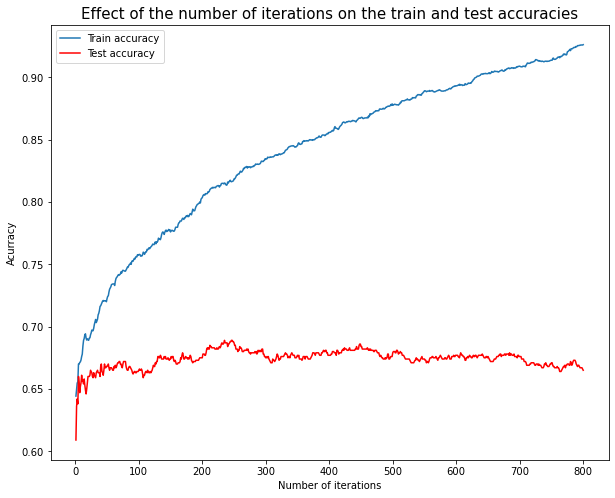

In [36]:
# your code here

train_scores = list(ada_boost.staged_score(X_train80, y_train80))
test_scores = list(ada_boost.staged_score(X_val, y_val))

n_iterations = [i for i in range(1,801)]

plt.figure(figsize = (10, 8))
plt.plot(n_iterations, train_scores,label="Train accuracy")
plt.plot(n_iterations, test_scores, label="Test accuracy", color='red')
plt.xlabel("Number of iterations")
plt.ylabel('Acurracy', fontsize=10)
plt.legend()
plt.title("Effect of the number of iterations on the train and test accuracies", fontsize = 15)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. For easier comparison you should arrange your plots in a row. What trends do you see in the training and validation accuracies and how would you explain this behavior?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

_Points:_ 4

Depth increases as training accuracy reaches higher values. 

Increasing depth reduces the curvature of the testing accuracy line: 
- Depth = 1: test accuracy is *increasing*
- Depth = 2: accuracy is roughly *unchanged/constant*
- Depth = 3 or 4: accuracy *decreases*

As we increase the our tree's depth, we will see that the validation accuracy decreases and the training accuracy increases. This is evidence of overfitting. 

AdaBoost's prowess comes from building an ensemble combining weak learners to build a complex model. If we try to build a complex model by building an ensemble of complex learners (deep trees), we hinder our test accuracy, which is what happens with depths of 2 onwards. This is overfitting, and is why we see better results using weak learners (such as in the case of the shallow tree of depth one). 

In [37]:
# Models:

depths = [1,2,3,4]
n_iterations = [i for i in range(1,801)]

depth_1 = [[], []]
depth_2 = [[], []]
depth_3 = [[], []]
depth_4 = [[], []]

boosts = [depth_1, depth_2, depth_3, depth_4]

for i,b in zip(depths, boosts):
    
        model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i),
                                   learning_rate=learning_rate, 
                                   n_estimators=800)
        
        model.fit(X_train80, y_train80)
        b[0].append(list(model.staged_score(X_train80, y_train80)))
        b[1].append(list(model.staged_score(X_val,y_val)))
        

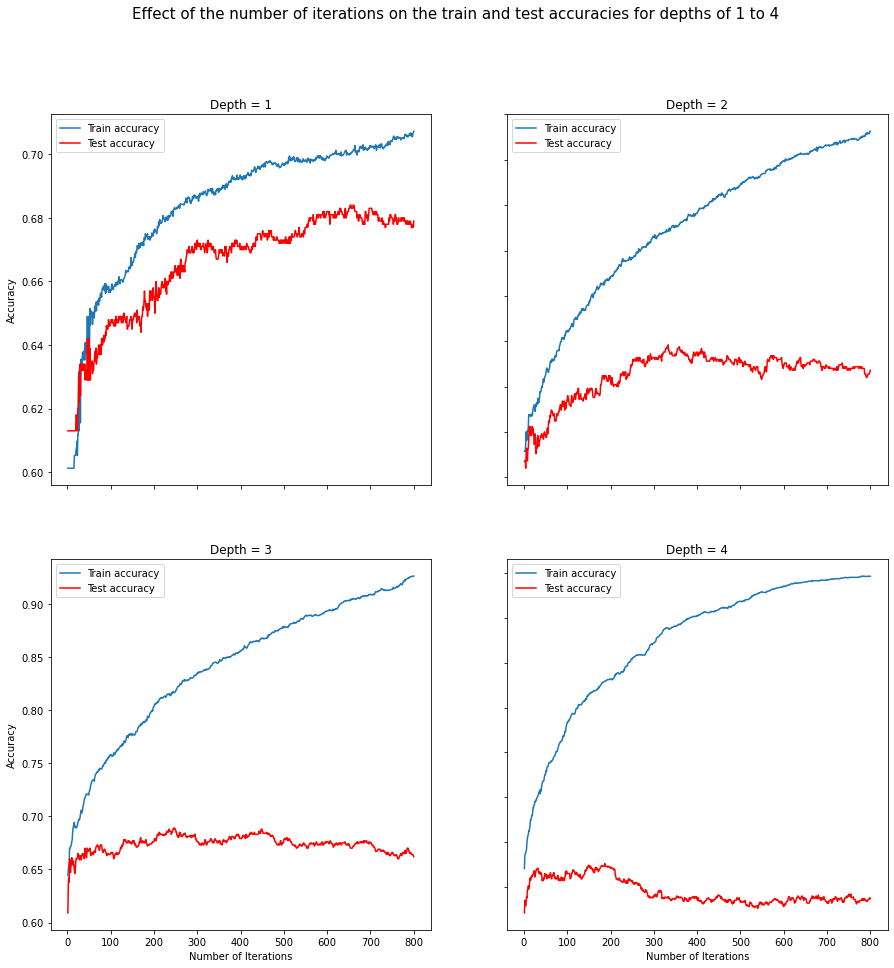

In [38]:
# Plotting:

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15, 15))
plt.suptitle('Effect of the number of iterations on the train and test accuracies for depths of 1 to 4', 
             fontsize = 15)


# Various positions where figure can be on the plot
positions = [[0, 0], [0, 1], [1, 0], [1, 1]]

for i,b in zip(positions,boosts):
    axs[i[0], i[1]].plot(n_iterations, b[0][0], label='Train accuracy')
    axs[i[0], i[1]].plot(n_iterations, b[1][0], label='Test accuracy', color='red')
    
for ax, depth in zip(axs.flat, depths):
    ax.set_title(f'Depth = {depth}')
    ax.set(xlabel='Number of Iterations', ylabel='Accuracy')
    ax.label_outer()
    ax.legend(loc='upper left')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.5** Based on the plots from Question 4.4, what combination of base learner depth and the number of iterations seems optimal and why?

**Note:** Feel free to make use of additional code to make your decision here if that is helpful. 
</div>

_Points:_ 3

Our goal is for the accuracy to be as high as posisble. Simply looking at the plots indicates that the combination of **330 iterations with a depth of 2** gives us the highest validation accuracy, and is therefore optimal. 

In [39]:
# your code here

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.6** Fit a final AdaBoostClassifier on the **entire train set** using the base learner depth and number of iterations you identified as optimal in the previous question. Keep the learning rate at 0.05 as before. Store the train and test accuracies in `ada_train_acc` and `ada_test_acc` respectively. How does the performance of this model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

_Points:_ 5

- Q2: bagging 50 trees of depth 20 gave us train and test accuracy of $0.9998$ and $0.6846$ respectively. 
- Q3: random forest of depth 20 and 55 trees gave us train and test accuracy of $1$ and $0.6829$, respectively. 
Training accuracies are excessively high in both of these models. This is characteristic of overfitting. 

The `AdaBoostClassifier` has classification accuracies that are much closer to each other, and we have an improvement in our testing accuracy: the training and test accuracies are $74.70%$ and 69.52%. We are more confident in this case that we are not overfitting.

In [ ]:
# your code here

optimal_depth = 2
optimal_n_iterations = 330

optimal_ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=optimal_depth),
                                   learning_rate = learning_rate, 
                                   n_estimators = optimal_n_iterations)

optimal_ada.fit(X_train, y_train)

ada_train_acc = optimal_ada.score(X_train, y_train)
ada_test_acc = optimal_ada.score(X_test, y_test)

In [ ]:
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Understanding [15 pts]</div> 

[Return to contents](#contents)

This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other course materials to answer these questions.
    

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

</div>

_Points:_ 5

Common points between bagging and boosting are that they are both *ensemble* methods that leverage several models. 
Predictions are then made using the mean of the combination of these models. We rely on both these methods to *reduce overfitting* as they are both able to fit complex decision boundaries without overfitting to the noise in the training data. 



The differences between the two are firstly that, while bagging relies on a classic mean, boosting relies on a *weighted* average. Secondly, bagging takes a sample of the same training data as input for each model while boosting updates the training data (boostrapping). This last part can be by either working on the residuals or adding weights. Also, Boosting is a linear combination of the ensemble rather than a average. The weights of the linear combination are a penalty term $\lambda$.
Finally, it is worth mentioning that bagging does not decrease bias while boosting does. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.2** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

</div>

_Points:_ 3

The impact of having too many trees for both boosting and bagging is *overfitting*.

Having too many trees is worse in boosting than in bagging. Bagging involves averaging predicting models. This means that eventually, the average will become less and less affected as the sample size of models increases. 

Boosting involves constantly and adding and penalising, which continuously increases model complexity. Each model in the sequence focuses its efforts on the most difficult classification tasks that were badly handled by the previous model. 



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

</div>

_Points:_ 2

Bagging is more suited towards parralelization. This is because each tree of the ensemble method, as well as its predictions, are created independently. However, in the case of boosting, each new tree that is added will take as input data that emanates from the previous tree's output. This means that it is impossible to parallelize the workload.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.4** Which of these techniques can be extended to regression tasks? Describe how this can be done.

</div>

_Points:_ 5

Both of these techniques can be extended to regression tasks. This can be done by maintaining the *same* pipeline but using Decision Tree *regressors* as opposed to classifiers. The way they work is very similar: their prediction for a new observation is the average of all the variables contained in the leaf that the observation falls into. 

In the case of *bagging*: a linear regression is a simple average rather than a majority average that we use in the case of a classification problem.
In the case of *boosting*: we make a initial prediction, calculate residuals from the previous prediction, add the new model with a penalty weight $\lambda$ to the previous term. This will bring us closer to the true value as we repeat this process until we meet some stopping criteria.

<!-- END QUESTION -->

**This concludes HW6. Thank you!**

[Return to contents](#contents)